**Entregable nro 3: Predicción con redes recurrentes (RNN)**

Librerías básicas necesarias

In [1180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

Se importa el drive y se carga el dataset

In [1181]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1182]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/dengue-dataset.csv')

Este dataset posee datos sobre los casos mensuales presentados de Dengue desde 1998 hasta 2014

In [1183]:
df.head()

,data,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima
0,1998-01-01,237,179.2,25.7,20.2,28.1
1,1998-02-01,331,226.3,25.1,20.0,28.0
2,1998-03-01,562,149.1,24.8,22.4,27.2
3,1998-04-01,187,46.4,22.7,18.1,26.0
4,1998-05-01,32,88.3,19.2,15.7,22.9


In [1184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   data                  204 non-null    object 
 1   casos-confirmados     204 non-null    int64  
 2   chuva                 196 non-null    float64
 3   temperatura-media     204 non-null    float64
 4   temperatura-mininima  204 non-null    float64
 5   temperatura-maxima    204 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.7+ KB


In [1185]:
df.describe()

,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima
count,204.000000,196.000000,204.000000,204.000000,204.000000
mean,357.539216,116.650000,22.200980,17.679412,25.565196
std,1741.814759,96.631613,2.399363,3.336316,2.249864
min,0.000000,0.800000,16.400000,8.200000,19.100000
25%,6.000000,43.850000,20.100000,15.075000,23.800000
50%,17.500000,86.650000,22.700000,18.150000,26.200000
75%,84.500000,177.925000,24.225000,20.400000,27.200000
max,20428.000000,452.800000,27.200000,23.500000,30.100000


Establecemos el formato de la columna data para optimizar el manejo del dataset

In [1186]:
df['data']=pd.to_datetime(df['data'],format= '%Y-%m-%d')

Chequeo de valores faltantes

In [1187]:
df.isna().sum()

data                    0
casos-confirmados       0
chuva                   8
temperatura-media       0
temperatura-mininima    0
temperatura-maxima      0
dtype: int64

In [1188]:
df[df['chuva'].isnull()]


,data,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima
18,1999-07-01,1,NaN,19.6,17.1,22.1
19,1999-08-01,3,NaN,19.8,10.8,24.8
53,2002-06-01,50,NaN,20.9,18.7,22.9
79,2004-08-01,0,NaN,19.9,14.7,23.8
115,2007-08-01,17,NaN,20.8,18.0,23.5
126,2008-07-01,8,NaN,19.2,17.1,22.6
151,2010-08-01,10,NaN,19.6,13.5,24.3
175,2012-08-01,12,NaN,20.3,17.5,21.6


Los datos faltantes se encuentran en la columna de precipitaciones, no es recomendable utilizar la media total para rellenarlos debido a la variacion intra anual. Debido a esto se busca rellenar los datos faltantes con la media entre los meses. Para esto creo la columna 'Mes'.

In [1189]:
df['Mes'] = df['data'].dt.month


Y observo la media de precipitaciones de cada mes

In [1190]:
df.groupby(['Mes']).mean()['chuva']

<ipython-input-1190-9cb75224a3b1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['Mes']).mean()['chuva']


Mes
1     282.570588
2     166.111765
3     142.900000
4      66.317647
5      60.911765
6      45.706250
7      47.386667
8      32.208333
9      54.182353
10    105.635294
11    151.847059
12    206.864706
Name: chuva, dtype: float64

Relleno los valores faltantes con los datos de la media observado para cada mes.

In [1191]:
df.loc[[18, 126]] = df.loc[[18, 126]].fillna(47.38)
df.loc[[19, 79, 115, 151, 175]] = df.loc[[19, 79, 115, 151, 175]].fillna(32.20)
df.loc[53] = df.loc[53].fillna(45.70)
df.loc[[18, 19, 53, 79, 115, 126, 151, 175]]

,data,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima,Mes
18,1999-07-01,1,47.38,19.6,17.1,22.1,7
19,1999-08-01,3,32.20,19.8,10.8,24.8,8
53,2002-06-01,50,45.70,20.9,18.7,22.9,6
79,2004-08-01,0,32.20,19.9,14.7,23.8,8
115,2007-08-01,17,32.20,20.8,18.0,23.5,8
126,2008-07-01,8,47.38,19.2,17.1,22.6,7
151,2010-08-01,10,32.20,19.6,13.5,24.3,8
175,2012-08-01,12,32.20,20.3,17.5,21.6,8


Establesco como índice la columna data y me aseguro de que el dataset esté ordenado por esta columna (ya que voy a trabajar con un modelo temporal)


In [1192]:
df=df.set_index('data')
df.sort_index(inplace= True)

Observamos si es que existen outliers

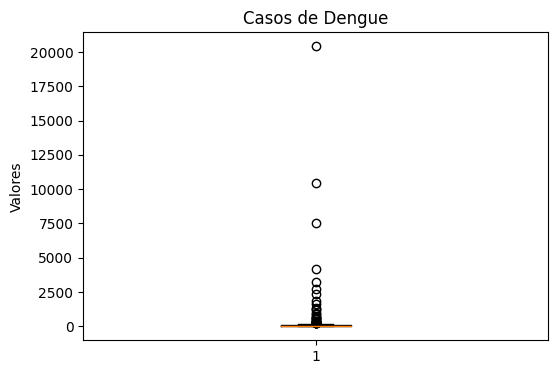

In [1193]:
plt.figure(figsize=(6, 4))
plt.boxplot(df['casos-confirmados'])
plt.title('Casos de Dengue')
plt.ylabel('Valores')
plt.show()

In [1194]:
df.shape

(204, 6)

Elimino los outliers basándome definiendo los límites inferior y superior segun el rango intercuartílico

In [1195]:
Q1 = df['casos-confirmados'].quantile(0.25)
Q3 = df['casos-confirmados'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df1 = df[(df['casos-confirmados'] > lower_bound) & (df['casos-confirmados'] < upper_bound)]

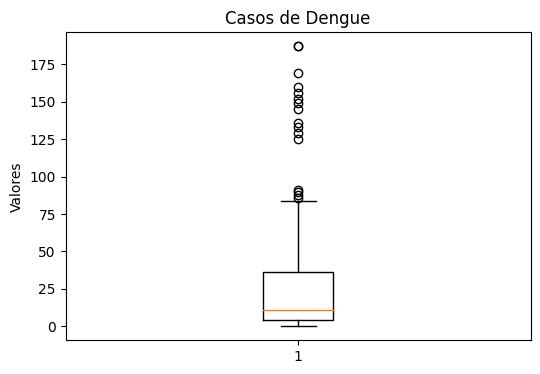

In [1196]:
plt.figure(figsize=(6, 4))
plt.boxplot(df1['casos-confirmados'])
plt.title('Casos de Dengue')
plt.ylabel('Valores')
plt.show()

In [1197]:
df1.shape

(169, 6)

Creo un array con los casos-confirmados para poder trabajr en el modelo de red neuronal


In [1198]:
array_casos= df1['casos-confirmados'].values

In [1199]:
print(array_casos)

[187  32  11   6   4   7   7   5   8   7  12  27  49   8   3   1   3   3
   0   0   4   6  11  21  15   8   4   4   3   0   2   2   5  32  38 160
 136  21  13  10   2   2   5  86 156  50   8   9   6   4   7  22  90  91
 125  76  28   7   2   0   0   1   0   3   9   8   6   3   1   0   0   0
   0   0   0   3   5   7   8  38  29  17   8   2   2   0   0   3   8  24
 187 129  31   7  16  10  17  10  11 169  67  17  35  49  57  42  40  37
  72  79  21  10   8   9   2   8   6  14  17  29  53  40  25  16   2   3
   2   3   3   7  65  84  11  10   5   5   8  12  68 133  26  11  13  23
  22  20  49  53 152  88  18  12   8   6  11  25 145  36  26  35  30  21
  50 149  55  40  40  57  37]


Divido el dataset en Base (para poder entrenar y calibrar el modelo) y en test (para evaluarlo)

In [1200]:
corte_80 = int(0.8 * len(array_casos))
array_base= array_casos[:corte_80]
array_test= array_casos[corte_80:]
print('Array base:')
print(array_base)
print('Array test:')
print(array_test)

Array base:
[187  32  11   6   4   7   7   5   8   7  12  27  49   8   3   1   3   3
   0   0   4   6  11  21  15   8   4   4   3   0   2   2   5  32  38 160
 136  21  13  10   2   2   5  86 156  50   8   9   6   4   7  22  90  91
 125  76  28   7   2   0   0   1   0   3   9   8   6   3   1   0   0   0
   0   0   0   3   5   7   8  38  29  17   8   2   2   0   0   3   8  24
 187 129  31   7  16  10  17  10  11 169  67  17  35  49  57  42  40  37
  72  79  21  10   8   9   2   8   6  14  17  29  53  40  25  16   2   3
   2   3   3   7  65  84  11  10   5]
Array test:
[  5   8  12  68 133  26  11  13  23  22  20  49  53 152  88  18  12   8
   6  11  25 145  36  26  35  30  21  50 149  55  40  40  57  37]


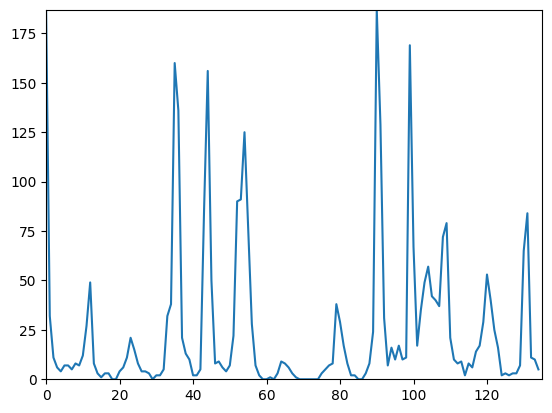

In [1201]:
plt.plot(array_base)
plt.xlim(0, len(array_base))  # Ajusta los límites del eje x
plt.ylim(0, max(array_base))  # Ajusta los límites del eje y


plt.show()

Creo la función window_transform_series para poder crear el conjunto X e y acordes para el correcto funcionamiento de la red RNN

In [1202]:
def window_transform_series(series, window_size):
    X = []
    y = []

    for i in range(window_size, len(series)):
      data_slice = series[i-window_size : i]
      target = series[i]

      X.append(data_slice)
      y.append(target)


    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)

    return X,y

In [1203]:
window_size = 5
X,y = window_transform_series(array_base, window_size=window_size)

In [1204]:
X_test,y_test = window_transform_series(array_test, window_size=window_size)

Chequeo si coinciden las filas

In [1205]:
assert np.shape(X)[0] == np.shape(y)[0]

In [1206]:
assert np.shape(X_test)[0] == np.shape(y_test)[0]

Divido en train y en validación

In [1207]:
from sklearn.model_selection import train_test_split

In [1208]:

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, random_state=42, shuffle= False)
corte_70= int(len(X)*0.7) #esto va a servir más adelante en el gráfico


Normalizo todos los datos para un mejor funcionamiento de la red RNN

In [1209]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler



scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)
scaler_y= MinMaxScaler()
y_train = scaler_y.fit_transform(y_train)
y_val= scaler_y.transform(y_val)
y_test= scaler_y.transform(y_test)

Establesco la formato necesario al conjunto X para que pueda ser leído por el modulo RNN LSTM

In [1210]:
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_val = np.asarray(np.reshape(X_val, (X_val.shape[0], window_size, 1)))

Importo librerías necesarias para crear la arquitectura de la red neuronal

In [1211]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow import keras



In [1212]:
model = Sequential()
model.add(layers.LSTM(5, input_shape=(window_size, 1)))#, return_sequences= True))
#model.add(layers.LSTM(5))
model.add(layers.Dense(1))
optimizer= Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')


In [1213]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 5)                 140       
                                                                 
 dense_33 (Dense)            (None, 1)                 6         
                                                                 
Total params: 146 (584.00 Byte)
Trainable params: 146 (584.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entreno en modelo con los hiperparámetros establecidos

In [1214]:
history = model.fit(X_train, y_train, epochs=35, batch_size=20, validation_data=(X_val, y_val))


Epoch 1/35
5/5 [==============================] - 3s 141ms/step - loss: 0.0634 - val_loss: 0.0379
Epoch 2/35
5/5 [==============================] - 0s 17ms/step - loss: 0.0471 - val_loss: 0.0309
Epoch 3/35
5/5 [==============================] - 0s 16ms/step - loss: 0.0471 - val_loss: 0.0304
Epoch 4/35
5/5 [==============================] - 0s 14ms/step - loss: 0.0435 - val_loss: 0.0315
Epoch 5/35
5/5 [==============================] - 0s 16ms/step - loss: 0.0423 - val_loss: 0.0335
Epoch 6/35
5/5 [==============================] - 0s 12ms/step - loss: 0.0421 - val_loss: 0.0334
Epoch 7/35
5/5 [==============================] - 0s 16ms/step - loss: 0.0411 - val_loss: 0.0317
Epoch 8/35
5/5 [==============================] - 0s 17ms/step - loss: 0.0398 - val_loss: 0.0303
Epoch 9/35
5/5 [==============================] - 0s 17ms/step - loss: 0.0385 - val_loss: 0.0295
Epoch 10/35
5/5 [==============================] - 0s 13ms/step - loss: 0.0375 - val_loss: 0.0294
Epoch 11/35
5/5 [===========

Grafico la función de perdida a lo largo de las épocas establecidas.

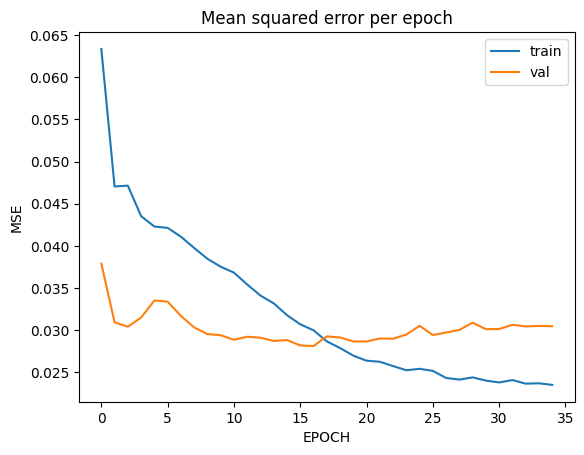

In [1215]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean squared error per epoch')
plt.ylabel('MSE')
plt.xlabel('EPOCH')
plt.legend(['train', 'val'])
plt.show()

Realizo las predicciones

In [1216]:
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)

2/2 [==============================] - 0s 6ms/step


Obtengo las métricas de evaluación

In [1217]:
training_error = model.evaluate(X_train, y_train, verbose=0)
print('Error de entrenamiento = ' + str(training_error))

val_error = model.evaluate(X_val, y_val, verbose=0)
print('Error de test = ' + str(val_error))

Error de entrenamiento = 0.023489205166697502
Error de test = 0.03047679364681244


Normalizo el array_base para poder comparar los gráficos de prediccion y realidad.

In [1218]:
array_base1 = np.array(array_base)
array_base1 = array_base1.reshape(-1, 1)


#array_base1= scaler.fit_transform(array_base1)

In [1219]:
pred_train_unscaled = scaler_y.inverse_transform(train_predict)
pred_val_unscaled= scaler_y.inverse_transform(val_predict)



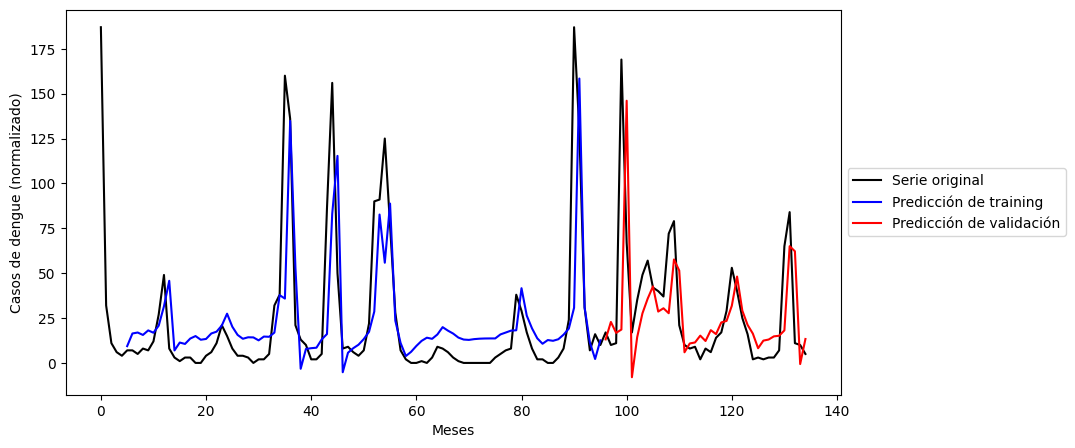

In [1220]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
# Graficar serie original
plt.plot(array_base1,color = 'k')

# Graficar la predicción de entrenamiento
split_pt = corte_70 + window_size
plt.plot(np.arange(window_size, split_pt, 1), pred_train_unscaled, color = 'b')

# Graficar la predicción de validación
plt.plot(np.arange(split_pt, split_pt + len(pred_val_unscaled),1),pred_val_unscaled,color = 'r')

# Agregar rótulos
plt.xlabel('Meses')
plt.ylabel('Casos de dengue')
plt.legend(['Serie original','Predicción de training','Predicción de validación'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Ahora paso a probar el modelo con el conjunto test:

Establezco el formato necesario de X_test para un correcto funcionamiento del modelo.

In [1221]:
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

Realizo la predicción

In [1222]:
pred_test =model.predict(X_test)

1/1 [==============================] - 0s 27ms/step


In [1223]:
pred_test_unscaled = scaler_y.inverse_transform(pred_test)
pred_y_unscaled = scaler_y.inverse_transform(y_test)


Grafico el resultado para mejor observación:

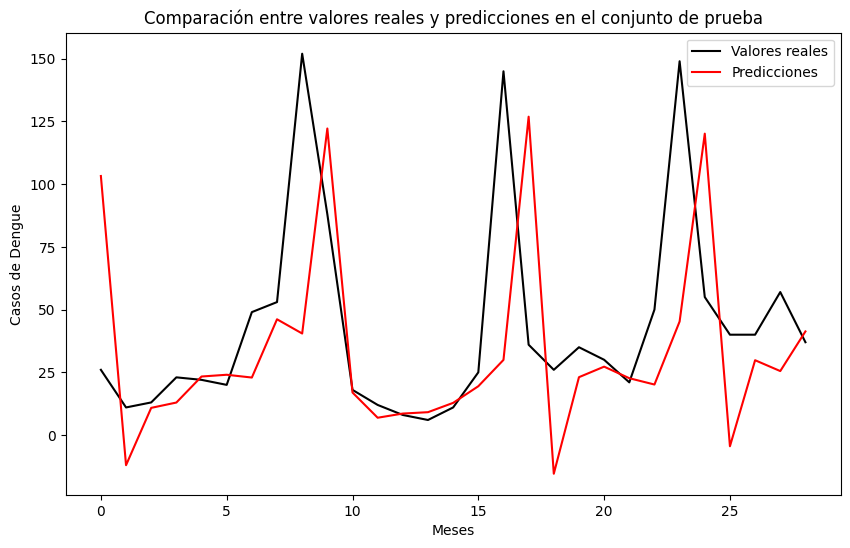

In [1224]:
plt.figure(figsize=(10, 6))
plt.plot(pred_y_unscaled, label='Valores reales', color='black')
plt.plot(pred_test_unscaled, label='Predicciones', color='red')
plt.title('Comparación entre valores reales y predicciones en el conjunto de prueba')
plt.xlabel('Meses')
plt.ylabel('Casos de Dengue')
plt.legend()
plt.show()



Evaluación de la calidad de las predicciones:


In [1225]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print(f'Error cuadrático medio (MSE): {mse}')

Error cuadrático medio (MSE): 0.0639632572544099


**DISCUSIÓN Y CONCLUSIÓN**

Se generó un modelo RNN LSTM univariado-unistep con el objetivo de predecir la cantidad de casos que se presentaran de Dengue en los distintos meses. Debido a la estructura del modelo, sólo se tuvo en cuenta la feature a predecir (casos confirmados), ignorando la temperatura y las precipitaciones ('chuva'). Se seleccionaron los mejores hiperparámetros a través de diversas combinaciones, logrando así durante el entrenamiento un modelo aceptable pero no óptimo (debido a que su MSE era mayor a 0.02 en el conjunto validación). La simplicidad del modelo es debida a la cantidad de datos disponibles, es sabido que una red neuronal aprende de forma óptima patrones complejos mientras más datos existan para alimentarla (si el dataset no posee tanta variación la red neuronal puede aprender sin la necesidad de mucha información), es por esto que al no poseer muchos datos no se complejizó el modelo (aumentando capas neuronales, nro de units, disminuyendo el learning_rate del optimizador, incrementado epochs, disminuyendo batch_size,etc) ya que al hacerlo tendía a overfitear demasiado.

Con respecto al desempeño con el conjunto test, lamentablemente no fue el esperado. Al modelo le costó adaptarse al set de datos nuevo y obtuvo un alto MSE. La performance del modelo podría ser mejorada quizás con la implementación de otras features (temperatura, precipitación) a través de un modelo multivariado unistep, pero debido a la simplicidad de este trabajo no se abordó esta opción.

En conclusión, el modelo tuvo un desempeño aceptable durante su calibración pero no pudo rendir de forma óptima ante el conjunto test. Para mejorar su performance se recomienda incrementar la cantidad de datos e incluir las features que pueden aportar información para una mejor predicción.

